# This notebook is for presenting how our algorithms work real time!

### Let's first create a random graph with 4x4 grid size and R_b/a ~ 3, and then run the different optimization schemes

In [ ]:
using Bloqade
using BloqadeMIS
using Random
using Optim
Random.seed!(42)
using PythonCall
plt = pyimport("matplotlib.pyplot");

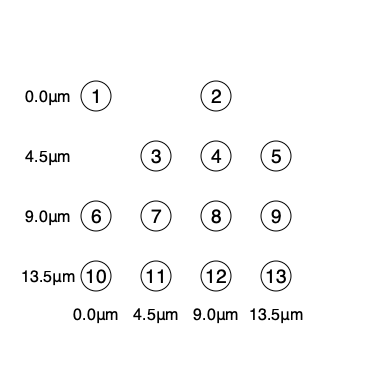

In [36]:
Random.seed!(2)
a=4.5
atoms = generate_sites(SquareLattice(), 4,4; scale = a) |> random_dropout(0.2)

In [37]:
Rb=sqrt(3*sqrt(5))*a
print(Rb)

11.65509028850108

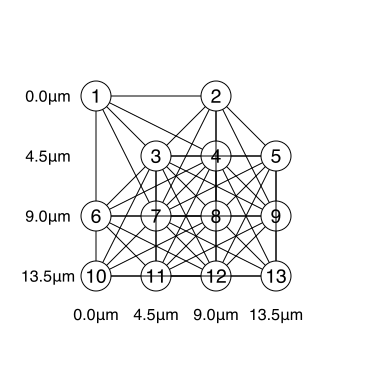

In [38]:
Bloqade.plot(atoms, blockade_radius = Rb)

[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6]

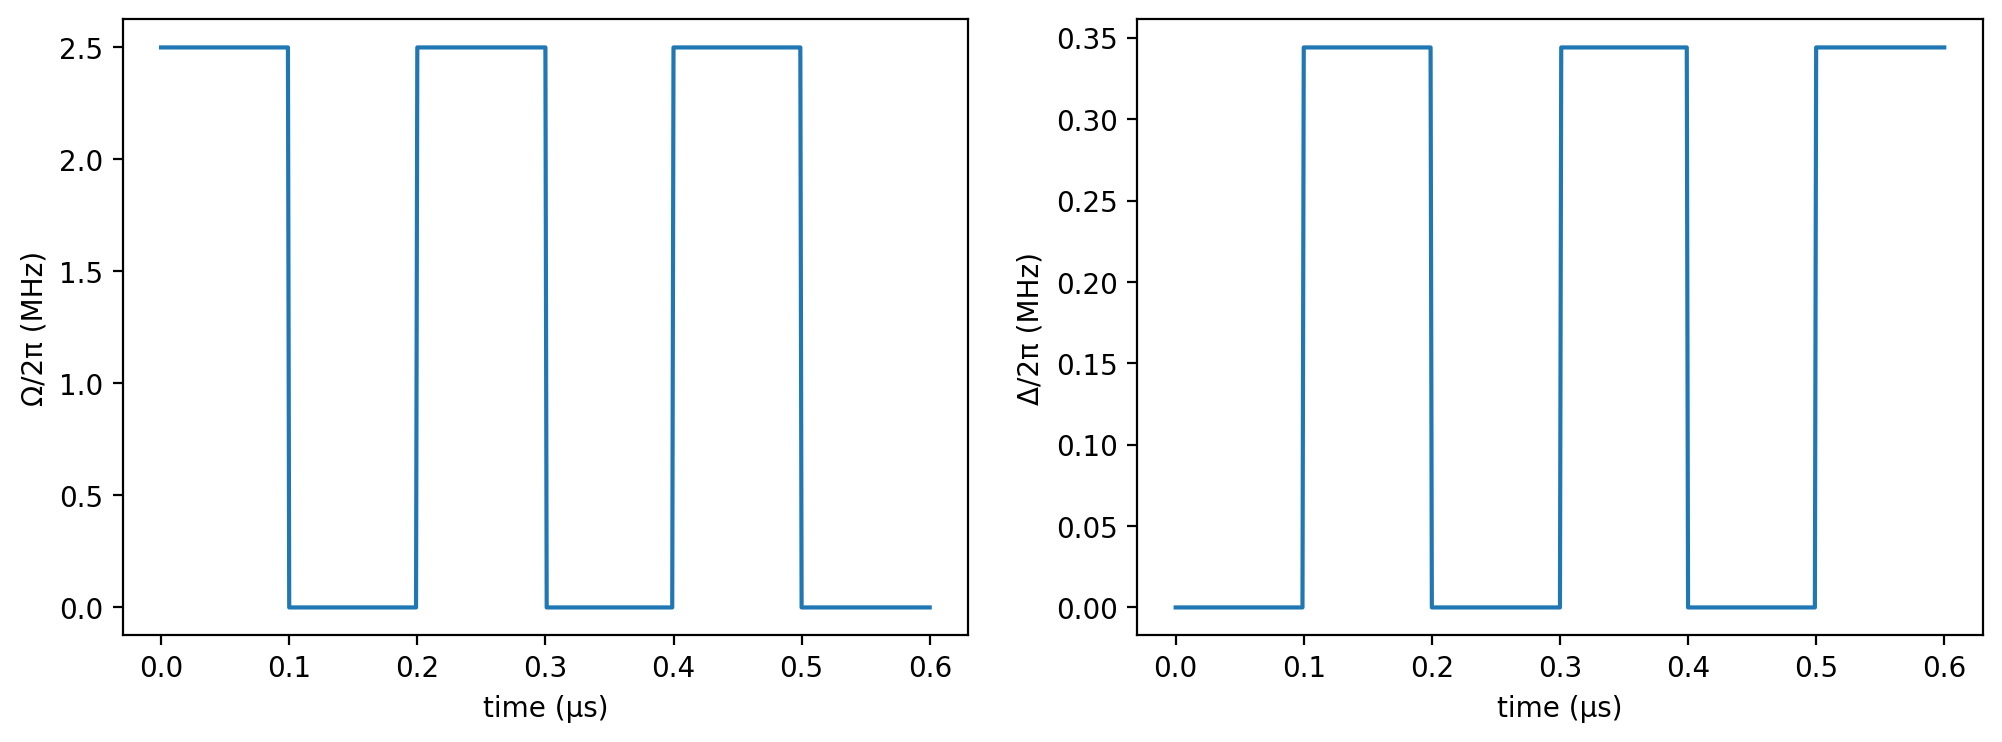

In [40]:
#Total evolution time
T_max = 3.0

#Fix Δ according to the desired Rydberg radius
C6 = 2π * 862690;
Ω_max = 2π*2.5
Δ_max = C6 / Rb^6


durations = fill(0.1, 6)
clocks = [0, cumsum(durations)...]
print(clocks)
Ω2 = piecewise_constant(; clocks = clocks, values = repeat([Ω_max, 0.0], 3))
Δ2 = piecewise_constant(; clocks = clocks, values = repeat([0.0, Δ_max], 3))

fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (12, 4))
Bloqade.plot!(ax1, Ω2)
ax1.set_ylabel("Ω/2π (MHz)")
Bloqade.plot!(ax2, Δ2)
ax2.set_ylabel("Δ/2π (MHz)")
fig

In [41]:
hamiltonian2 = rydberg_h(atoms; Ω = Ω2, Δ = Δ2)
nsites = length(atoms)
subspace = blockade_subspace(atoms, 7.5)  # we run our simulation within the blockade subspace
prob2 = KrylovEvolution(zero_state(subspace), clocks, hamiltonian2)
emulate!(prob2);

In [42]:
loss_MIS(reg) = -rydberg_density_sum(reg)
loss_MIS(prob2.reg)

-2.2409626608248066

In [43]:
function loss_piecewise_constant(atoms::AtomList, x::AbstractVector{T}) where {T}
    @assert length(x) % 2 == 0
    Ω_max = 2π*2.5
    Δ_end = (2π * 862690) / 11.65509028850108^6
    p = length(x) ÷ 2

    # detuning and rabi terms
    durations = abs.(x)   # the durations of each layer of the QAOA pulse take the optimizing vector x as their input
    clocks = [0, cumsum(durations)...]
    Ωs = piecewise_constant(; clocks = clocks, values = repeat(T[Ω_max, 0.0], p))
    Δs = piecewise_constant(; clocks = clocks, values = repeat(T[0.0, Δ_end], p))

    hamiltonian = rydberg_h(atoms; Ω = Ωs, Δ = Δs)
    subspace = blockade_subspace(atoms, 11.65509028850108)  # we run our simulation within the blockade subspace
    prob = KrylovEvolution(zero_state(Complex{T}, subspace), clocks, hamiltonian)
    emulate!(prob)
    return -rydberg_density_sum(prob.reg), prob.reg
end

loss_piecewise_constant (generic function with 1 method)

In [44]:
x0 = durations
rydberg_density, reg1 = loss_piecewise_constant(atoms, x0)
rydberg_density

-1.1589595530159942

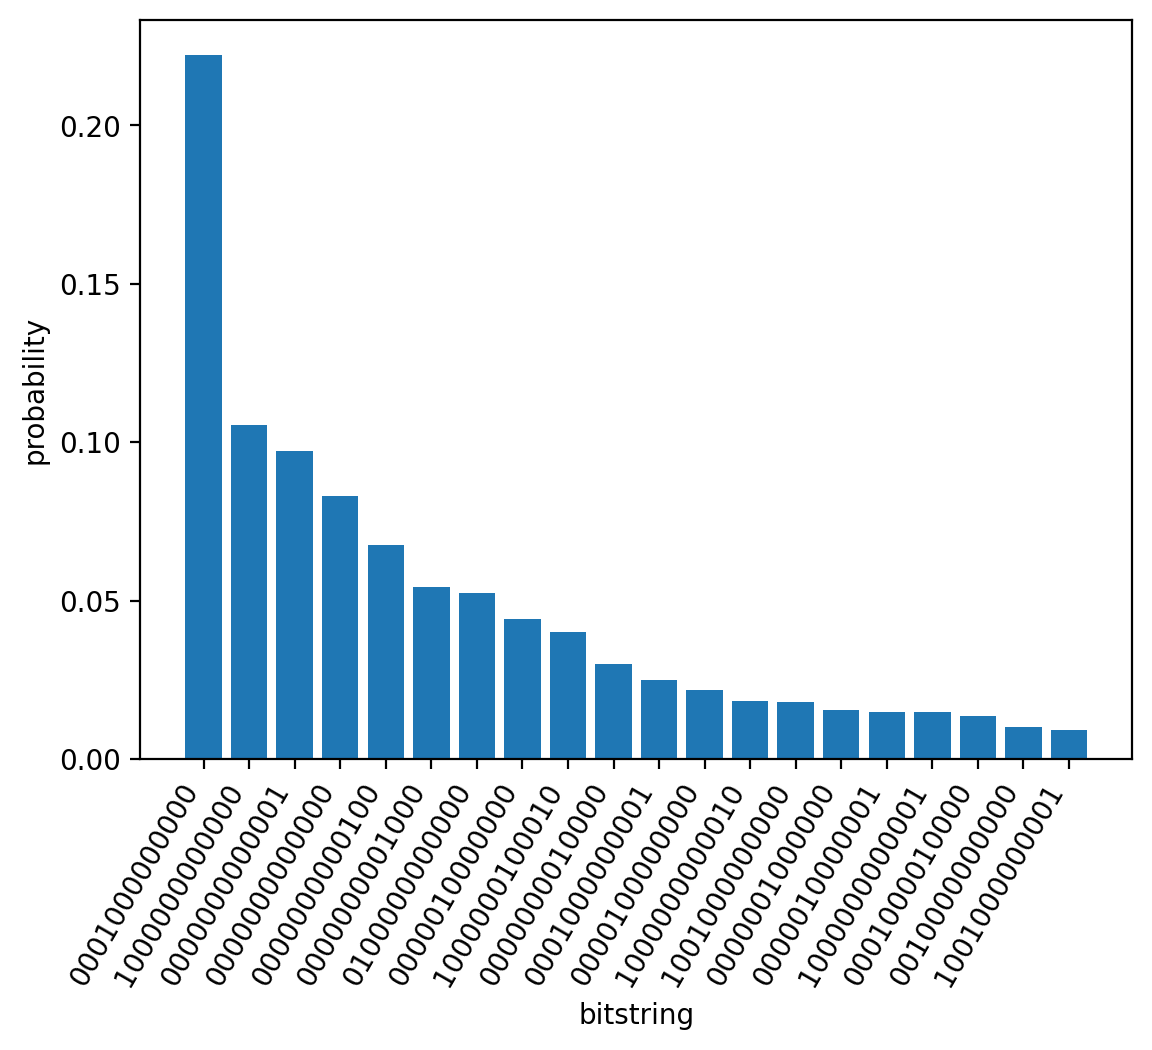

In [45]:
bitstring_hist(reg1; nlargest = 20)

In [46]:
optresult = Optim.optimize(x -> loss_piecewise_constant(atoms, x)[1], x0)

rydberg_density_final, reg1_final = loss_piecewise_constant(atoms, optresult.minimizer)
rydberg_density_final

-2.1869431838482436

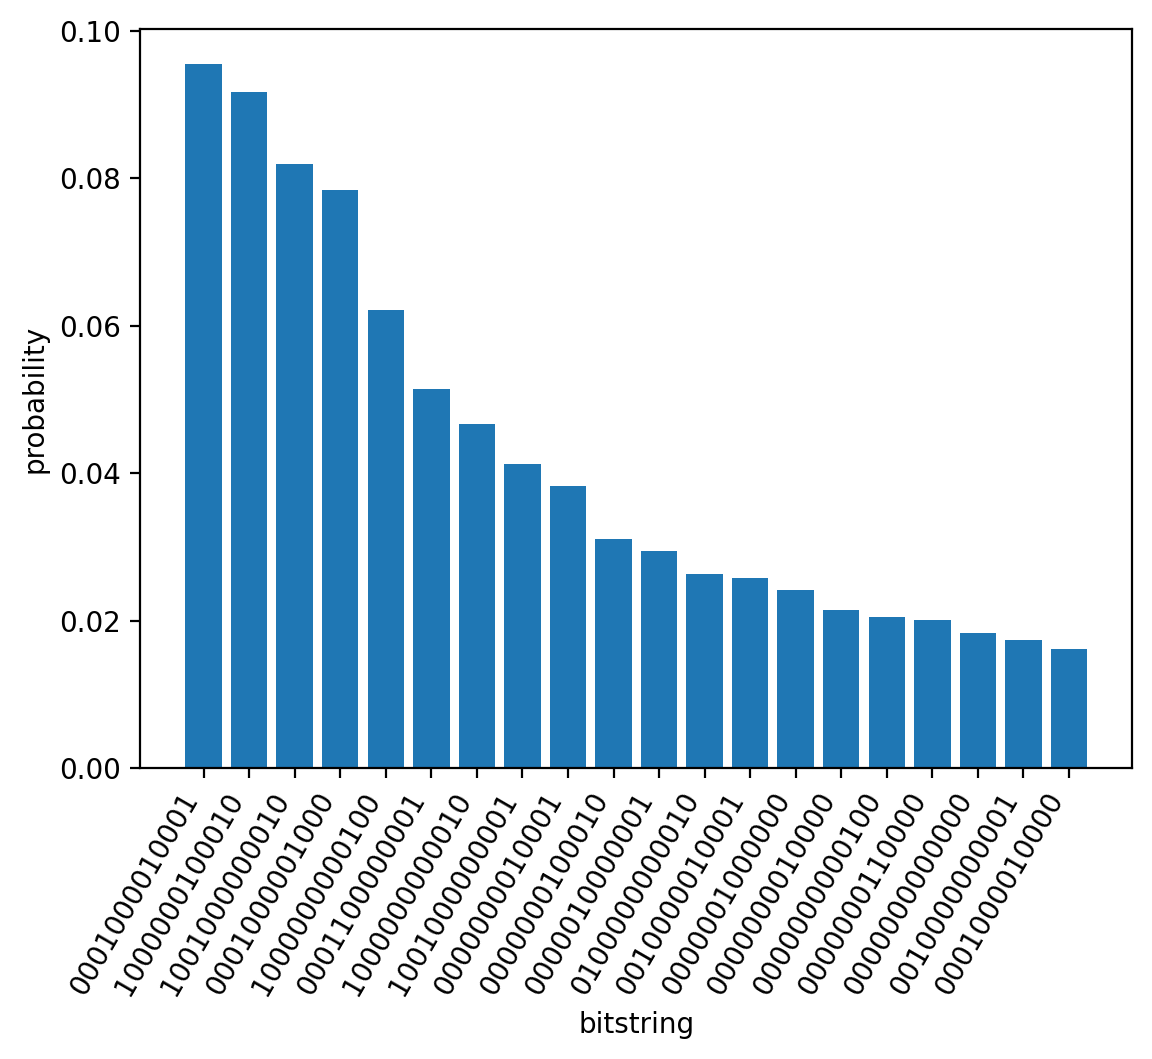

In [47]:
bitstring_hist(reg1_final; nlargest = 20)

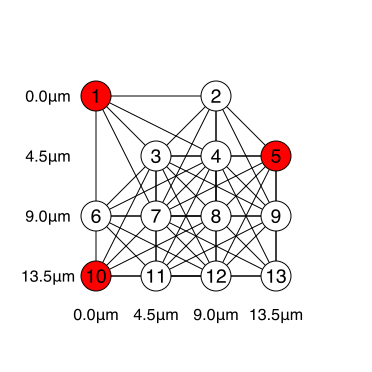

In [48]:
best_bit_strings = most_probable(reg1_final, 3)

Bloqade.plot(atoms, blockade_radius = Rb; colors = [iszero(b) ? "white" : "red" for b in best_bit_strings[1]])

### 5x5 grid

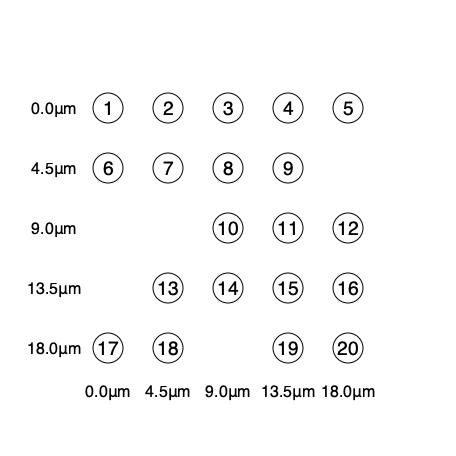

In [53]:
Random.seed!(3)
a=4.5
atoms = generate_sites(SquareLattice(), 5,5; scale = a) |> random_dropout(0.2)

In [54]:
Rb = sqrt(3*sqrt(10))*a

13.860316297084605

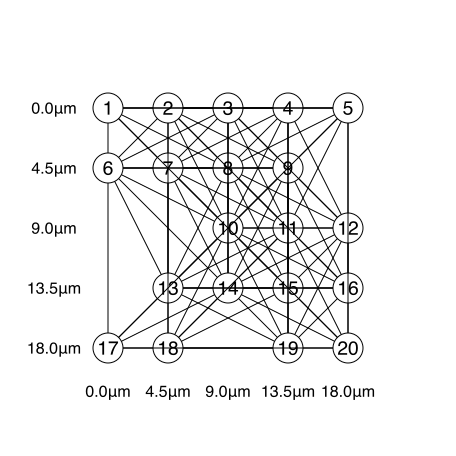

In [55]:
Bloqade.plot(atoms, blockade_radius = Rb)

# QAOA

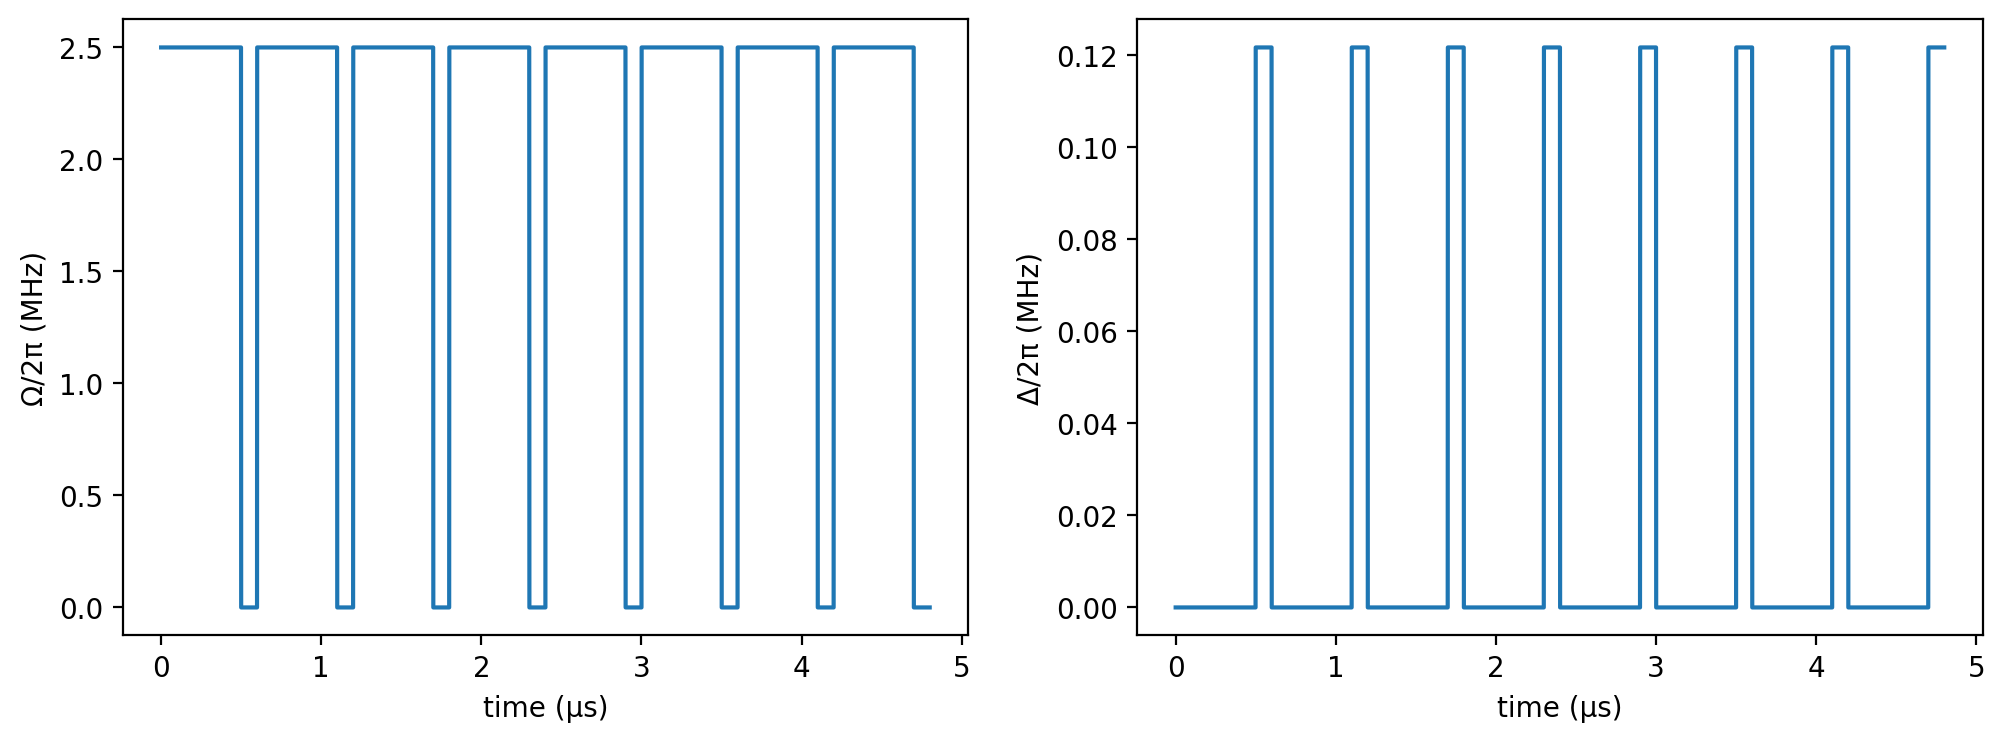

In [27]:
#Total evolution time
T_max = 4.0

#Fix Δ according to the desired Rydberg radius
C6 = 2π * 862690;
Ω_max = 2π*2.5
Δ_max = C6 / Rb^6
Δ_end = Δ_max

# durations = fill(0.5, 8)
durations = [0.5, 0.1, 0.5, 0.1, 0.5, 0.1, 0.5, 0.1, 0.5, 0.1, 0.5, 0.1, 0.5, 0.1, 0.5, 0.1]

clocks = [0, cumsum(durations)...]

Ω2 = piecewise_constant(; clocks = clocks, values = repeat([Ω_max, 0.0], 8))
Δ2 = piecewise_constant(; clocks = clocks, values = repeat([0.0, Δ_end], 8))

fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (12, 4))
Bloqade.plot!(ax1, Ω2)
ax1.set_ylabel("Ω/2π (MHz)")
Bloqade.plot!(ax2, Δ2)
ax2.set_ylabel("Δ/2π (MHz)")
fig

In [28]:
function loss_piecewise_constant(atoms::AtomList, x::AbstractVector{T}) where {T}
    @assert length(x) % 2 == 0
    Ω_max = 2π*2.5
    Δ_end = (2π * 862690) / 11.65509028850108^6
    p = length(x) ÷ 2

    # detuning and rabi terms
    durations = abs.(x)   # the durations of each layer of the QAOA pulse take the optimizing vector x as their input
    clocks = [0, cumsum(durations)...]
    Ωs = piecewise_constant(; clocks = clocks, values = repeat(T[Ω_max, 0.0], p))
    Δs = piecewise_constant(; clocks = clocks, values = repeat(T[0.0, Δ_end], p))

    hamiltonian = rydberg_h(atoms; Ω = Ωs, Δ = Δs)
    subspace = blockade_subspace(atoms, 11.65509028850108)  # we run our simulation within the blockade subspace
    prob = KrylovEvolution(zero_state(Complex{T}, subspace), clocks, hamiltonian)
    emulate!(prob)
    return -rydberg_density_sum(prob.reg), prob.reg
end

loss_piecewise_constant (generic function with 1 method)

In [29]:
x0 = durations
rydberg_density, reg1 = loss_piecewise_constant(atoms, x0)
rydberg_density

-2.5523278830015834

In [30]:
optresult = Optim.optimize(x -> loss_piecewise_constant(atoms, x)[1], x0)

rydberg_density_final, reg1_final = loss_piecewise_constant(atoms, optresult.minimizer)
rydberg_density_final

-2.8317413152760773

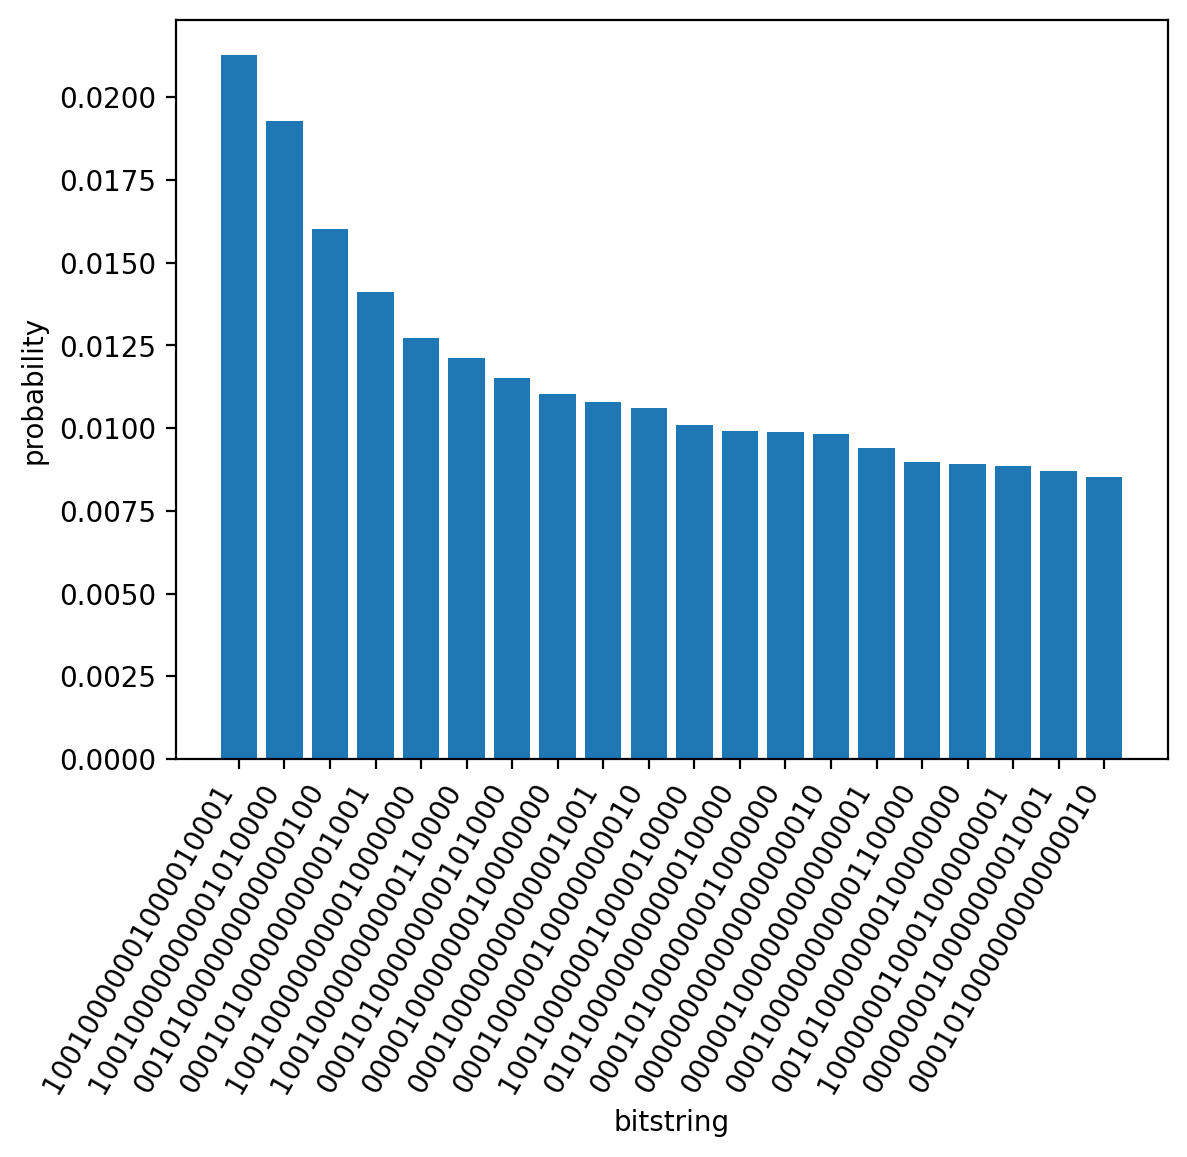

In [31]:
bitstring_hist(reg1_final; nlargest = 20)

In [32]:
probs(reg1_final)
best_bit_strings = most_probable(reg1_final, 10)

10-element Vector{DitStr{2, 20, Int64}}:
 10010000001000010001 ₍₂₎
 10010000000001010000 ₍₂₎
 00101000000000000100 ₍₂₎
 00010100000000001001 ₍₂₎
 10010000000001000000 ₍₂₎
 10010000000000110000 ₍₂₎
 00010100000000101000 ₍₂₎
 00001000000010000000 ₍₂₎
 00010000000000001001 ₍₂₎
 00010000010000000010 ₍₂₎

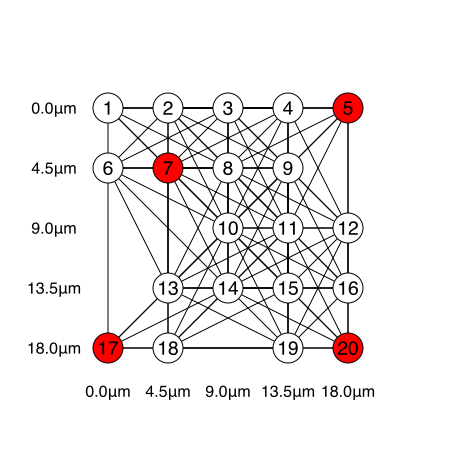

In [35]:
Bloqade.plot(atoms, blockade_radius = Rb; colors = [iszero(b) ? "white" : "red" for b in best_bit_strings[2]])

# Adiabatic Optimization Scheme

In [50]:
using GenericTensorNetworks

In [56]:
unit_graph = unit_disk_graph(atoms, Rb)
configs = GenericTensorNetworks.solve(IndependentSet(unit_graph), ConfigsMax())[]
MIS_config = configs.c[1]

10001000000000001001

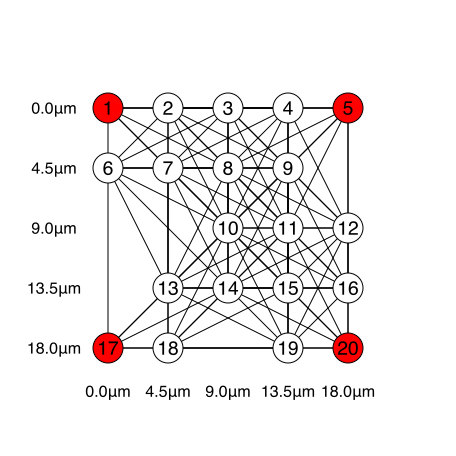

In [57]:
Bloqade.plot(atoms, blockade_radius = Rb; colors = [iszero(b) ? "white" : "red" for b in MIS_config])

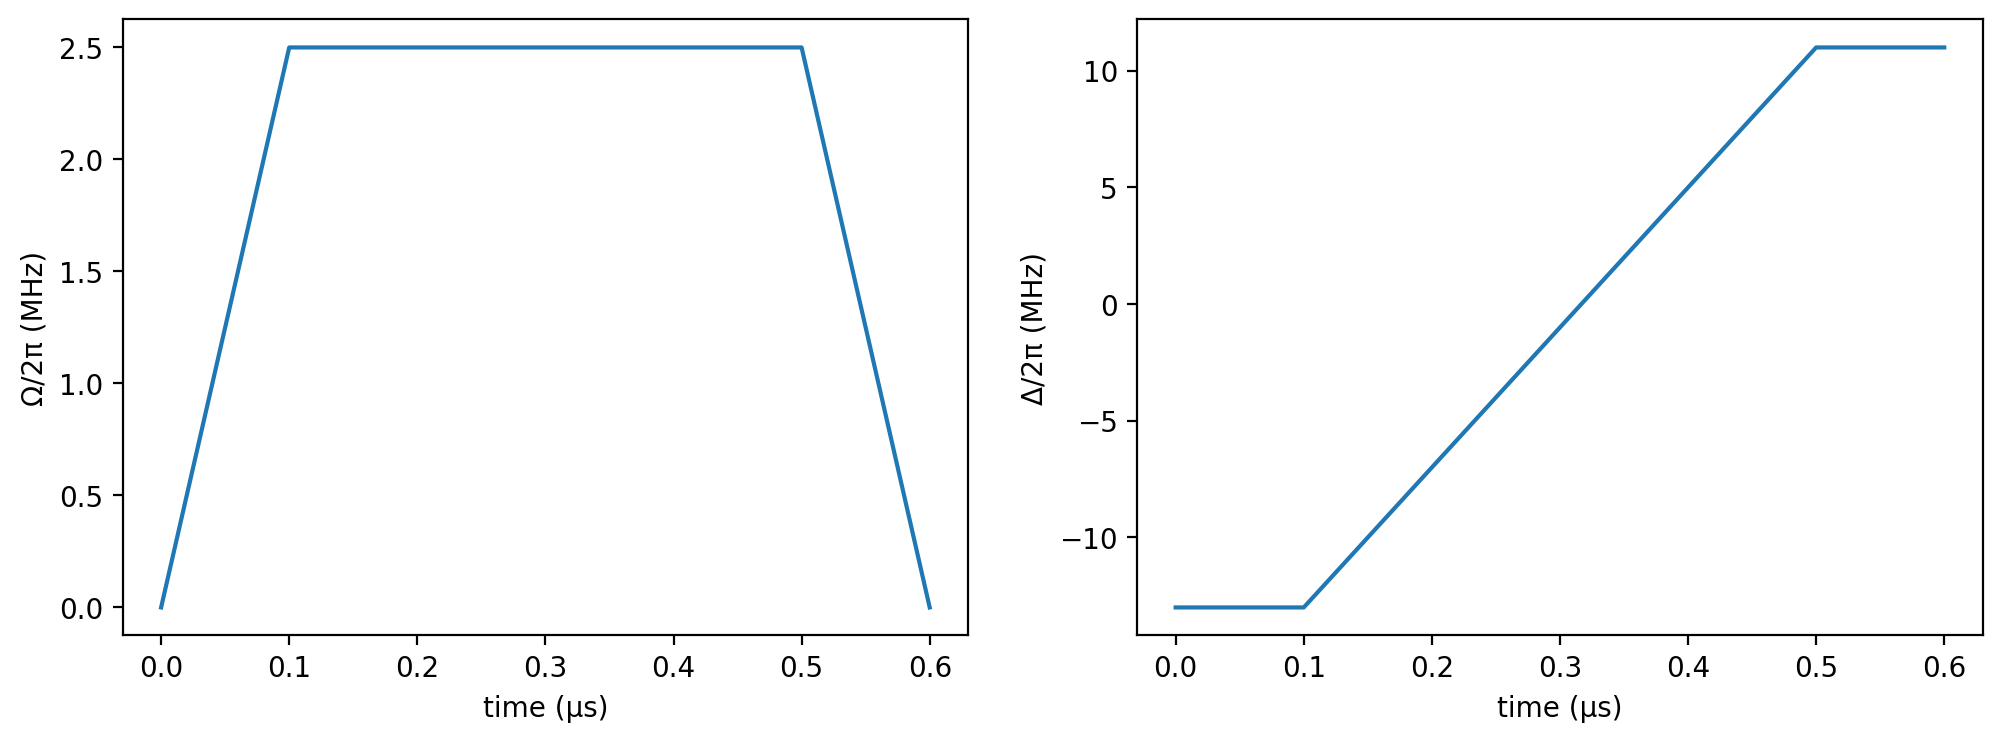

In [58]:
T_max = 0.6
Ω_max = 2π * 2.5
Ω = piecewise_linear(clocks = [0.0, 0.1, 0.5, T_max], values = [0.0, Ω_max, Ω_max, 0])
Δ_start = -2π * 13
Δ_end = 2π * 11
Δ = piecewise_linear(clocks = [0.0, 0.1, 0.5, T_max], values = [Δ_start, Δ_start, Δ_end, Δ_end])

plot, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (12, 4))
Bloqade.plot!(ax1, Ω)
ax1.set_ylabel("Ω/2π (MHz)")
Bloqade.plot!(ax2, Δ)
ax2.set_ylabel("Δ/2π (MHz)")
plot

In [59]:
hamiltonian = rydberg_h(atoms; Ω = Ω, Δ = Δ, ϕ=Waveform(t->0.0, T_max))
prob = SchrodingerProblem(zero_state(nqubits(hamiltonian)), T_max, hamiltonian)
emulate!(prob)

SchrodingerProblem:
  register info:
    type: ArrayReg{2, ComplexF64, Matrix{ComplexF64}}
    storage size: 8 bytes

  time span (μs): (0.0, 0.6)

  equation: 
    storage size: 496.000 MiB
    expression:
nqubits: 20
+
├─ [+] ∑ 2π ⋅ 8.627e5.0/|x_i-x_j|^6 n_i n_j
├─ [+] Ω(t) ⋅∑ e^{ϕ(t) ⋅ im} |0⟩⟨1| + e^{-ϕ(t) ⋅ im} |1⟩⟨0|
└─ [-] Δ(t) ⋅ ∑ n_i


    algorithm: DP8(; stage_limiter! = trivial_limiter!, step_limiter! = trivial_limiter!, thread = static(false),)
  options:
    save_everystep: false
    save_start: false
    save_on: false
    dense: false
    reltol: 1.0e-10
    abstol: 1.0e-10
    alias_u0: true


In [60]:
function get_MIS_prob(reg::Union{ArrayReg, SubspaceArrayReg}, configs) # want to maxmimize this
    prob = 0
    x = [parse(Int, reverse(string(x)); base=2) for x in configs.c]
    for (c, amp) in BloqadeMIS.ConfigAmplitude(reg)
        if c in x
            prob+=abs2(amp)
        end
    end
    return prob
end

get_MIS_prob(prob.reg, configs)

0.006818390644391471

In [61]:
function get_waves(params::Vector{Float64}) # returns the pulses as a function of certain parameters
    t_start, t_end, scale... = params
    t_start+=0.03
    T_max = 0.6
    t_end = T_max - t_end - 0.03
    t_interval = (t_end - t_start) / (length(scale) + 1)
    Ω_max = 2.5 * 2π
    Δ_start = -13 * 2π
    Δ_end = Δ0 = 11 * 2π

    Δ_clock = [0.0, t_start]
    Δ_val = [Δ_start, Δ_start]
    for i in 1:length(scale)
        push!(Δ_val, Δ0*scale[i])
        push!(Δ_clock, t_start + i*t_interval)
    end
    push!(Δ_val, Δ_end); push!(Δ_val, Δ_end)
    push!(Δ_clock, t_end); push!(Δ_clock, T_max)
    Δ = piecewise_linear(clocks = Δ_clock, values = Δ_val);
    Ω = piecewise_linear(clocks = [0.0, t_start, t_end, T_max], values = [0, Ω_max, Ω_max, 0]);
    return Ω, Δ
end

get_waves (generic function with 1 method)

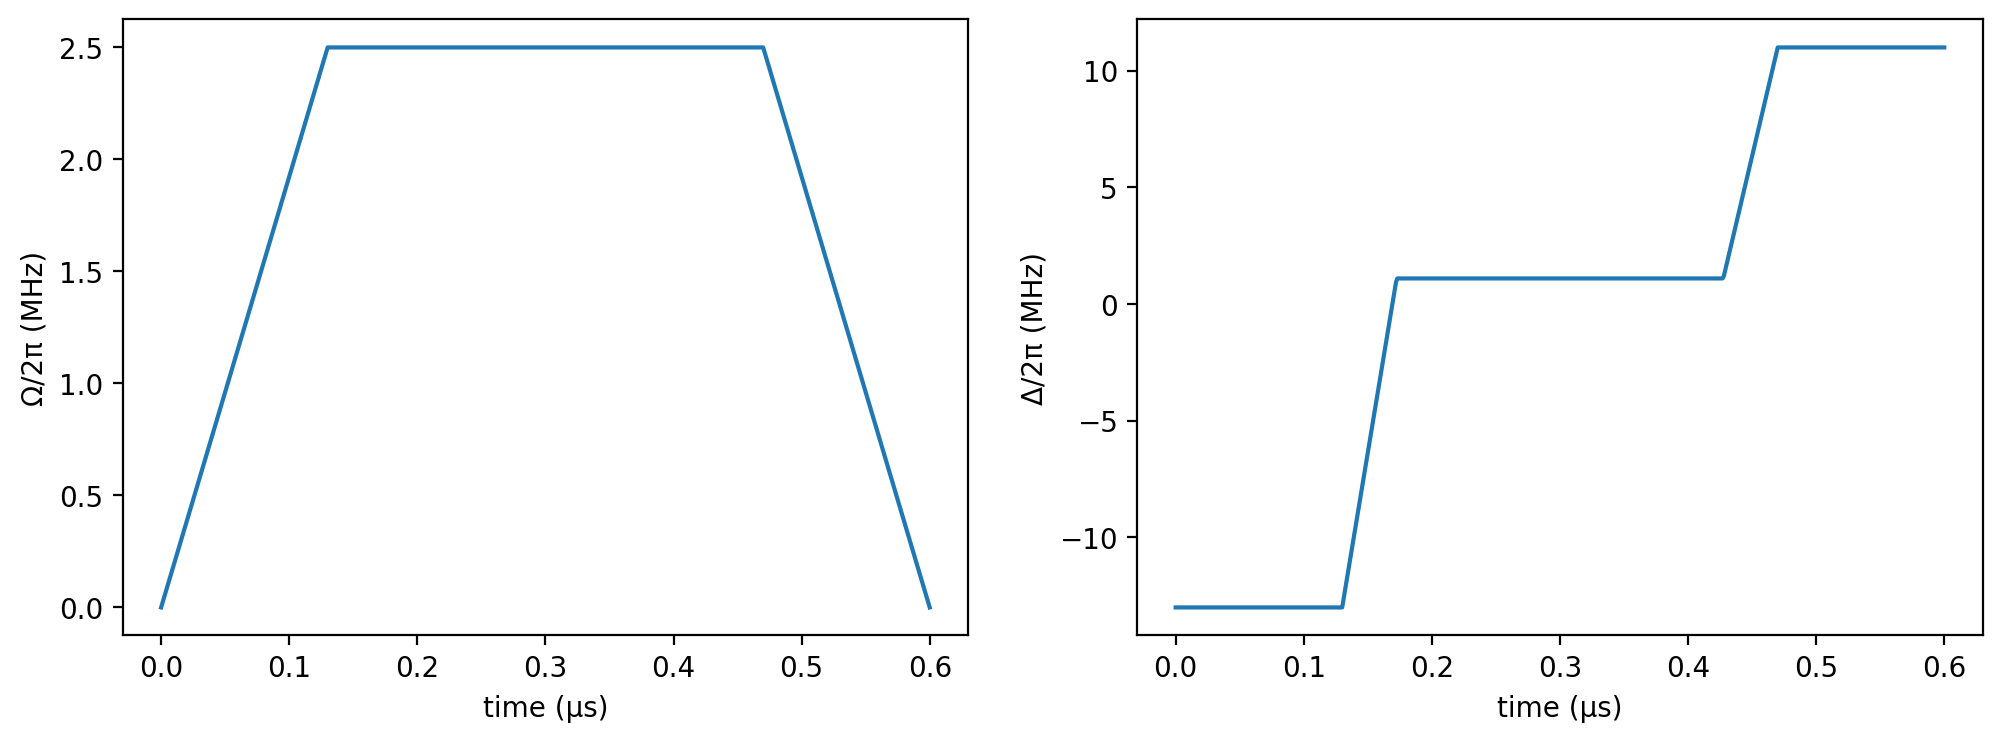

In [62]:
function plot_waves(params::Vector{Float64})
    Ω, Δ = get_waves(params)

    graph, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (12, 4))
    Bloqade.plot!(ax1, Ω)
    ax1.set_ylabel("Ω/2π (MHz)")
    Bloqade.plot!(ax2, Δ)
    ax2.set_ylabel("Δ/2π (MHz)")
    return graph
end

x0 = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]

plot_waves(x0)

In [63]:
function loss(atoms::AtomList, x::Vector{Float64}, configs)
    Ω, Δ = get_waves(x)
    hamiltonian = rydberg_h(atoms; Ω = Ω, Δ = Δ)
    subspace = blockade_subspace(atoms, 4.5)
    prob = SchrodingerProblem(zero_state(subspace), T_max, hamiltonian)
    emulate!(prob)
    return -get_MIS_prob(prob.reg, configs), prob.reg, Δ
end

optresult = Optim.optimize(x -> loss(atoms, x, configs)[1], x0)

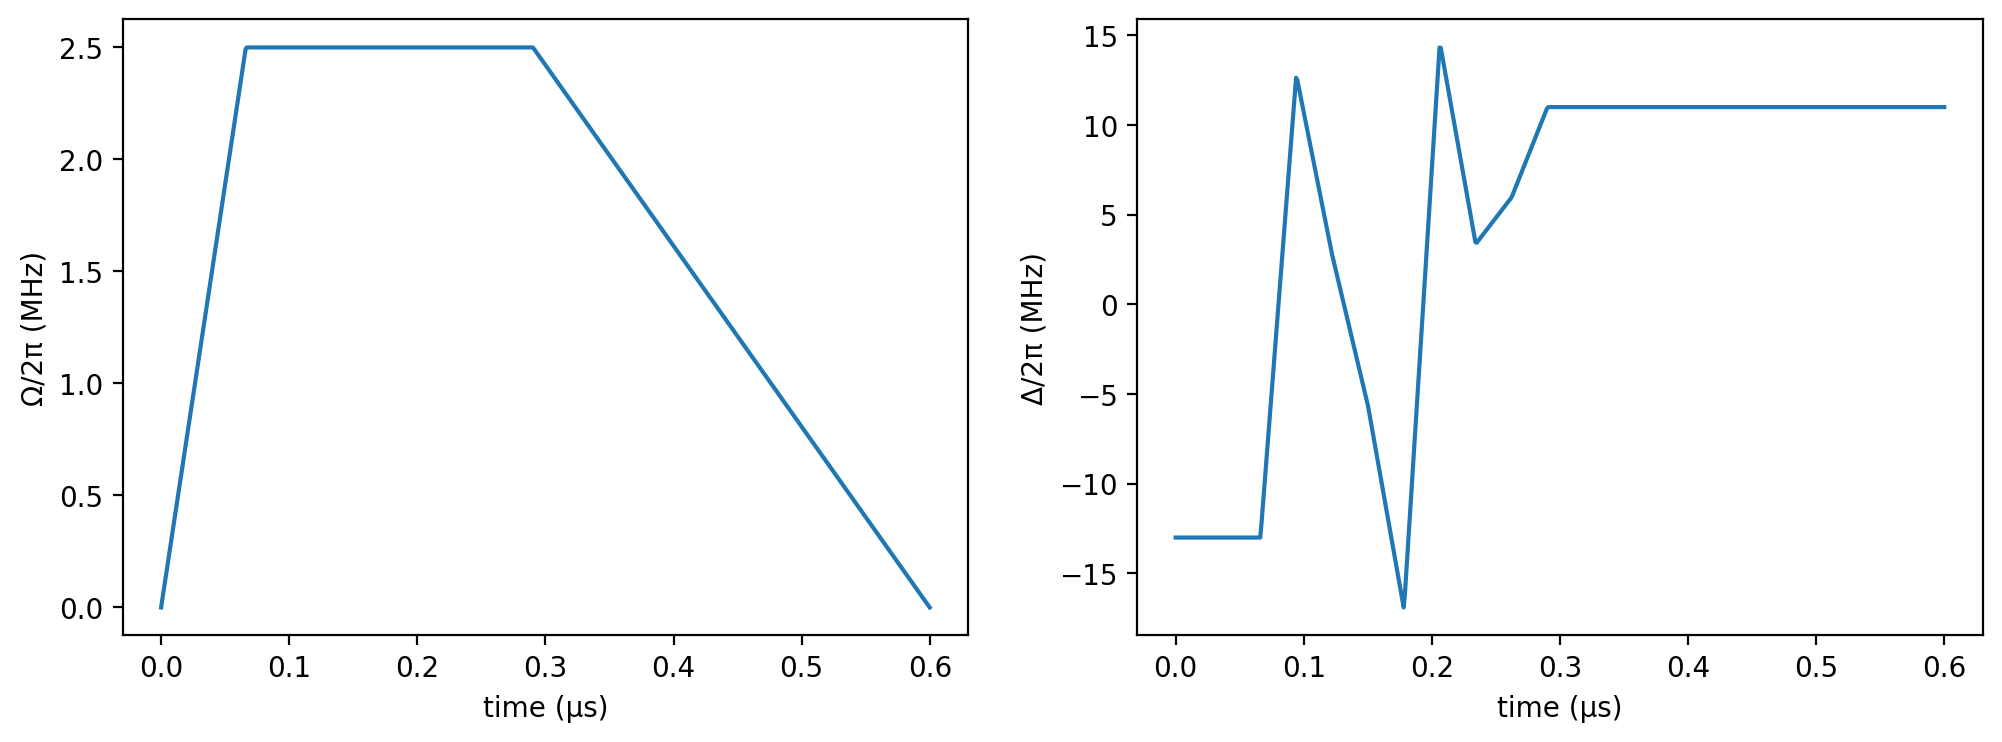

In [ ]:
plot_waves(optresult.minimizer)

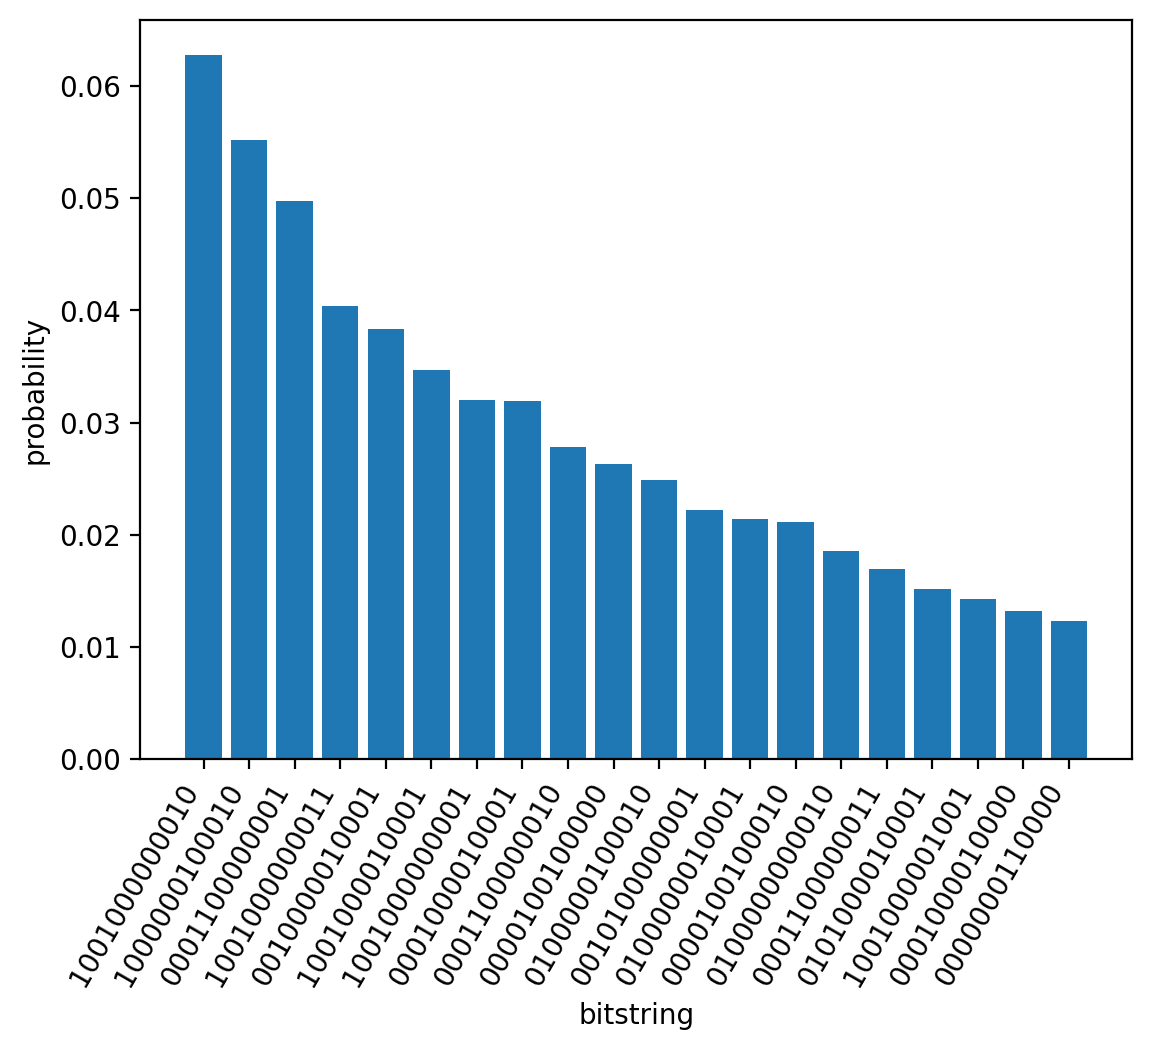

In [ ]:
Ω, Δ = get_waves(optresult.minimizer)
hamiltonian = rydberg_h(atoms; Ω = Ω, Δ = Δ, ϕ=Waveform(t->0.0, T_max))
prob = SchrodingerProblem(zero_state(nqubits(hamiltonian)), T_max, hamiltonian)
emulate!(prob)

bitstring_hist(prob.reg; nlargest = 20)

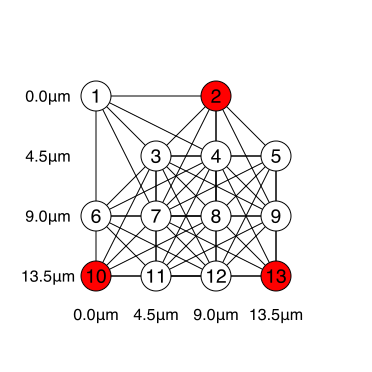

In [ ]:
best_bit_strings = most_probable(prob.reg, 3)

Bloqade.plot(atoms, blockade_radius = Rb; colors = [iszero(b) ? "white" : "red" for b in best_bit_strings[1]])